In [75]:
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

## Exercise: New-Keynesian Model Stochastic Simulation with Different Monetary Policies

You will compute two stochastic simulations of the new-Keynesian model. In the first, you will set $\phi_{\pi}=1.5$. In the second, you will set $\phi_{\pi}=100$. For both simulations, you will compute standard deviations and correlation coefficients for the simulated variables. Then you will answer questions about the two simulations.


### Equilibrium Conditions and Paramter Values

The most basic version of the New-Keynesian Model can be expressed as:

\begin{align}
y_t & = E_t y_{t+1}  - \left( r_{t} - \bar{r}\right) + g_t\\
i_{t} & = r_{t} + E_t \pi_{t+1}\\
i_{t} & = \bar{r} + \pi^T + \phi_{\pi}\big(\pi_t - \pi^T\big) + \phi_{y}\big(y_t - \bar{y}\big)\\
\pi_t -\pi^T & = \beta \left( E_t\pi_{t+1} - \pi^T\right)  + \kappa (y_t -\bar{y})+ u_t,
\end{align}

where: $y_t$ is (log) output, $r_t$ is the real interest rate, $i_t$ is the nominal interest rate, $\pi_t$ is the rate of inflation between periods $t-1$ and $t$, $\bar{r}$ is the long-run average real interest rate or the *natural rate of interest*, $\beta$ is the household's subjective discount factor, and $\pi^T$ is the central bank's inflation target. The coeffieints $\phi_{\pi}$ and $\phi_{y}$ reflect the degree of intensity to which the central bank *endogenously* adjusts the nominal interest rate in response to movements in inflation and output.

The variables $g_t$ and $u_t$ represent exogenous shocks to aggregate demand and inflation. They follow AR(1) processes:

\begin{align}
g_{t+1} & = \rho_g g_{t} + \epsilon^g_{t+1}\\
u_{t+1} & = \rho_u u_{t} + \epsilon^u_{t+1}
\end{align}

Note that the model *does not* contain a monetary policy shock process.

### Parameter Values:

Use the following parameter values to input the model. Note that the value for $\phi_{\pi}$ is empty for now.

| $$\bar{y}$$ | $$\beta$$ | $$\bar{r}$$    | $$\kappa$$ | $$\pi^T$$ | $$\phi_{\pi}$$ | $$\phi_y$$ | $$\rho_g$$ | $$\sigma_g$$    | $$\rho_u$$ | $$\sigma_u$$    |
|-------------|-----------|----------------|------------|-----------|----------------|------------|------------|-------------------|------------|-------------------|
| 0           | 0.995     | $$-\log\beta$$ | 0.25        | 0.02/4    | -            | 0.5/4      | 0.5        | 0.015 | 0.5        | 0.003 |


### Input Model and Solve

Refer to Week 9 lecture and discussion Notebooks for examples. Note that the model *does not* contain a monetary policy shock process.

In [76]:
# Create a variable called 'parameters' that stores the model parameter values in a Pandas Series
parameters = pd.Series(dtype=float)
parameters['y_bar'] = 0
parameters['beta'] = 0.995
parameters['r_bar'] = -np.log(parameters.beta)
parameters['kappa'] = 0.25
parameters['pi_T'] = 0.02/4
parameters['phi_pi'] = 1.5
parameters['phi_y'] = 0.5/4
parameters['rho_g'] = 0.5
parameters['rho_u'] = 0.5

# Create variable called 'var_names' that stores the variable names in a list with exogenous state variables
# ordered first, endogenous state variables ordered second, and control variables ordered last.
var_names = ['g','u','y','pi','i','r']

# Create variable called 'shock_names' that stores an exogenous shock name for each exogenous state variable.
shock_names = ['e_g','e_u']

# Define a function that evaluates the equilibrium conditions of the model solved for zero. PROVIDED
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters. PROVIDED
    p = parameters
    
    # Current variables. PROVIDED
    cur = variables_current
    
    # Forward variables. PROVIDED
    fwd = variables_forward

    # IS equation
    is_equation = fwd.y - (cur.r -p.r_bar) + cur.g - cur.y
    
    # Fisher_equation
    fisher_equation = cur.r + fwd.pi - cur.i
    
    # Monetary policy
    monetary_policy = p.r_bar + p.pi_T + p.phi_pi*(cur.pi - p.pi_T) + p.phi_y*cur.y - cur.i
    
    # Phillips curve
    phillips_curve = p.beta*(fwd.pi- p.pi_T) + p.kappa*cur.y + cur.u - (cur.pi-p.pi_T)
    
    # Demand process
    demand_process = p.rho_g*cur.g - fwd.g
    
    
    # Inflation process
    inflation_process = p.rho_u*cur.u - fwd.u
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
            is_equation,
            fisher_equation,
            monetary_policy,
            phillips_curve,
            demand_process,
            inflation_process
        ])

# Initialize the model into a variable named 'nk_model'
nk_model = ls.model(equations = equilibrium_equations,
                    n_states=2,
                    n_exo_states = 2,
                    var_names=var_names,
                    shock_names=shock_names,
                    parameters = parameters)

### Stochastic Simulation 1: $\phi_{\pi}=1.5$

Construct a stochastic simulation of the New-Keynesian model with the follwoing properties:

1. 401 periods. 
2. Seed for random number generator: 126.

Note that the shock covariance matrix is:

\begin{align}
\text{Covariance matrix} & = \left[\begin{array}{cc}\sigma_g^2 & 0\\ 0 & \sigma_u^2\end{array}\right]
\end{align}

Use the following values for $\sigma_g$ and $\sigma_u$ in the simulation:

| $$\sigma_g$$ | $$\sigma_u$$ |
|--------------|----------------|
| 0.015        | 0.003          |

In [77]:
# Set 'phi_pi' to 1.5 in nk_model.parameters
parameters['phi_pi'] = 1.5


# Compute the steady state numerically using .compute_ss() method of nk_model
guess = [0,0,0,0.01,0.01,0.01]
nk_model.compute_ss(guess)

# Print the computed steady state
print(nk_model.ss)

# Find the log-linear approximation around the non-stochastic steady state and solve using .approximate_and_solve() method of nk_model
# set argumement 'log_linear' to False
nk_model.approximate_and_solve(log_linear=False)

# Compute the stochastic simulation using the .stoch_sim() method of nk_model. Set seed to 126.
Sigma = [[0.015**2,0],[0,0.003**2]]
nk_model.stoch_sim(T=401,cov_mat=Sigma,seed=126)


g    -3.339790e-36
u    -6.465971e-36
y    -1.498504e-20
pi    5.000000e-03
i     1.001254e-02
r     5.012542e-03
dtype: float64


Construct a plot with simulated output and inflation plotted together. Multiply simulated output by 100 and simulated inflation by 400 since, by convention, we always annualize inflation and interest rates.

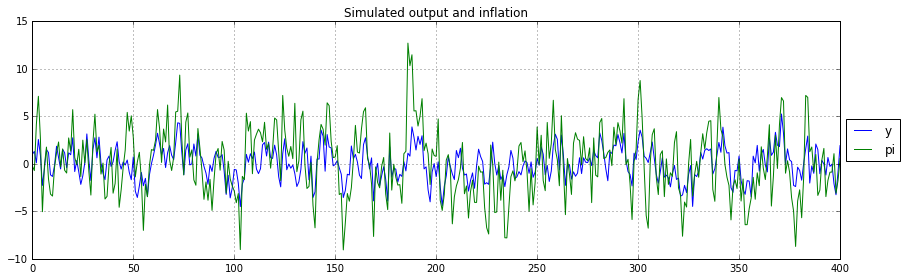

In [78]:
# Create a figure with dimensions 12x4. PROVIDED
fig = plt.figure(figsize=(12,4))

# Create the left axis. PROVIDED
ax = fig.add_subplot(1,1,1)

# Plot the simulated series for output (times 100) and inflation (times 400)
(nk_model.simulated['y']*100).plot(ax=ax,grid=True)
(nk_model.simulated['pi']*400).plot(ax=ax,grid=True)

ax.set_title('Simulated output and inflation')

fig.tight_layout()



# Construct legend. PROVIDED
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Compute the standard deviations of inflation $\pi_t$ (times 400), output $y_t$ (times 100), and the nominal interest rate $i_t$ (times 400) for the simulated series.

In [79]:
# Compute standard deviations of output (times 100), inflation (times 400), and the nominal interest rate (times 400)

nk_model.simulated[['y','pi','i']].std()*[100,400,400]


y     1.734673
pi    3.515388
i     5.892125
dtype: float64

Compute the coefficients of correlation of inflation $\pi_t$, output $y_t$, and the nominal interest rate $i_t$ for the simulated series. *You don't need to multiply the variables by anything because multiplication by a constant doeasn't affect correlations.*

In [68]:
# Compute correlation coefficients of output, inflation, and the nominal interest rate
nk_model.simulated[['y','pi','i']].corr()

,y,pi,i
y,1.000000,0.673382,0.749837
pi,0.673382,1.000000,0.994061
i,0.749837,0.994061,1.000000


### Stochastic Simulation 2: $\phi_{\pi}=100$

Construct another stochastic simulation of the New-Keynesian model with the follwoing properties:

1. 401 periods. 
2. Seed for random number generator: 126.

Note that the shock covariance matrix is:

\begin{align}
\text{Covariance matrix} & = \left[\begin{array}{cc}\sigma_g^2 & 0\\ 0 & \sigma_u^2\end{array}\right]
\end{align}

Use the following values for $\sigma_g$ and $\sigma_u$ in the simulation:

| $$\sigma_g$$ | $$\sigma_u$$ |
|--------------|----------------|
| 0.015        | 0.003          |

In [80]:
# Set 'phi_pi' to 100 in nk_model.parameters
parameters['phi_pi'] = 100

# Compute the steady state numerically using .compute_ss() method of nk_model
nk_model.compute_ss([0,0,0,0.01,0.01,0.01])

# Find the log-linear approximation around the non-stochastic steady state and solve using .approximate_and_solve() method of nk_model
# set argumement 'log_linear' to False
nk_model.approximate_and_solve(log_linear=False)

# Compute the stochastic simulation using the .stoch_sim() method of nk_model. Set seed to 126.
Sigma = [[0.015**2,0],[0,0.003**2]]
nk_model.stoch_sim(T=401,cov_mat=Sigma,seed=126)


Construct a plot with simulated output and inflation plotted together. Multiply simulated output by 100 and simulated inflation by 400 since, by convention, we always annualize inflation and interest rates.

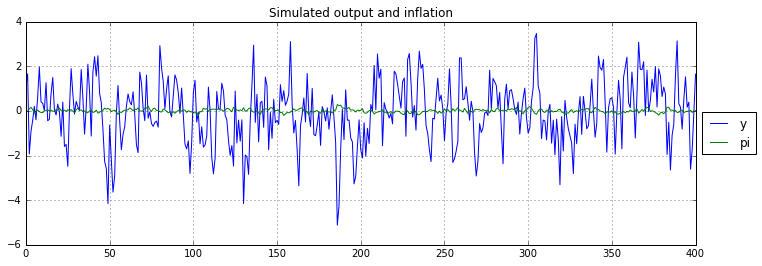

In [81]:
# Create a figure with dimensions 12x4. PROVIDED
fig = plt.figure(figsize=(12,4))

# Create the left axis. PROVIDED
ax = fig.add_subplot(1,1,1)

# Plot the simulated series for output (times 100) and inflation (times 400)
(nk_model.simulated['y']*100).plot(ax=ax, grid=True)
(nk_model.simulated['pi']*400).plot(ax=ax,grid=True)
ax.set_title('Simulated output and inflation')

# Construct legend. PROVIDED
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Compute the standard deviations of inflation $\pi_t$ (times 400), output $y_t$ (times 100), and the nominal interest rate $i_t$ (times 400) for the simulated series.

In [71]:
# Compute standard deviations of output (times 100), inflation (times 400), and the nominal interest rate (times 400)
nk_model.simulated[['y','pi','i']].std()*[100,400,400]

y     1.398902
pi    0.078721
i     7.619675
dtype: float64

Compute the coefficients of correlation of inflation $\pi_t$, output $y_t$, and the nominal interest rate $i_t$ for the simulated series. *You don't need to multiply the variables by anything because multiplication by a constant doesn't affect correlations.*

In [72]:
# Compute correlation coefficients of output, inflation, and the nominal interest rate
nk_model.simulated[['y','pi','i']].corr()

,y,pi,i
y,1.000000,-0.399476,-0.320912
pi,-0.399476,1.000000,0.996453
i,-0.320912,0.996453,1.000000


**Questions**

1. Based on your results, how did increasing $\phi_{\pi}$ from 1.5 to 100 affect the volatility of output over the business cycle?
2. Based on your results, how did increasing $\phi_{\pi}$ from 1.5 to 100 affect the volatility of inflation over the business cycle?
3. With $\phi_{\pi}=100$, the central bank is commited to raising the nominal interest rate by 100 percentage points for each one percent increase in the inflation rate. But the computed standard deviation of the nominal interest rate in the second simulation is about 7 percent, far less than 100. How do you explain this?

**Answers**

1.  increasing $\phi_{\pi}$ from 1.5 to 100 will make the volatility of output over the business cycle less volatile

2.  increasing $\phi_{\pi}$ from 1.5 to 100 will make the volatility of inflation over the business cycle less volatile

3.  in the monetary policy equation, the nominal interest rate is determined by phi_pi(the degree of intensity to which the central bank *endogenously* adjusts the nominal interest rate in response to movements in inflation and output) and inflation, and output. when phi-pi increase and inflation increases, but at the same time output decreases, and thus it will have a counter effect on directing affecting nominal interest rate.